In [5]:
#imports
import h5py
import numpy as np
import matplotlib.pyplot as plt
from astropy import units
import getdata
import densities
from scipy.optimize import curve_fit

from galpy.potential import TwoPowerSphericalPotential
from galpy.potential import HernquistPotential
from galpy.potential import PlummerPotential
from galpy.potential import DehnenSphericalPotential
from galpy.potential import DehnenCoreSphericalPotential
from galpy.potential import JaffePotential
from galpy.potential import NFWPotential
from galpy.potential import PowerSphericalPotential
from galpy.potential import PowerSphericalPotentialwCutoff
from galpy.potential import PseudoIsothermalPotential

First, the density profile is computed.

In [6]:
def getdensityprofile(nr_bins = 100, bin_distr = "adaptive"):
    bin_distr_options = ["linear", "logarithmic", "adaptive"]
    coords = getdata.coordskpc()
    mass = getdata.masssolar()
    
    if(bin_distr not in bin_distr_options):
        print(f"Error: bin_distr contains no valid distribution type. Choose from: " + str(bin_distr_options) + ", performing linear distribution instead.")
        bin_distr = "linear"

    if((nr_bins <= 1) or (isinstance(nr_bins, int) == False)):
        print(f"Error: bin amount must be a positive integer. Will now default to 1000 bins.")
        nr_bins = 1000

    coord_com = np.sum(coords,axis=0) / len(coords)
    coords_centred = coords - coord_com
    com_dist = np.sqrt(np.sum(coords_centred**2, axis=1))

    r_min = np.min(com_dist)
    r_max = np.max(com_dist)
    bins = np.linspace(r_min, r_max, nr_bins) 
    
    if(bin_distr == "adaptive"):
        com_dist_sorted = np.sort(com_dist)
        nr_particles = len(com_dist_sorted)

        bin_size = nr_particles // nr_bins
        bin_limit = nr_bins*bin_size
        bins = com_dist_sorted[:bin_limit].reshape(nr_bins, bin_size)

        bin_inner_bound = bins[:, 0]         
        bin_outer_bound = bins[:, -1]       
        bin_centre = np.mean(bins, axis=1)  

        bin_volume = (4/3)*np.pi*(bin_outer_bound**3 - bin_inner_bound**3)
        bin_density = bin_size*mass / bin_volume
        bin_poisson_error = np.sqrt(bin_size)*mass / bin_volume
        return bin_centre, bin_density, bin_poisson_error
        
    if(bin_distr == "linear"):
        bins = np.linspace(r_min, r_max, nr_bins)
    if(bin_distr == "logarithmic"):
        bins = np.logspace(np.log10(r_min.value), np.log10(r_max.value), nr_bins) * r_min.unit
    
    bin_counts, bin_edges = np.histogram(com_dist, bins=bins)
    bin_inner_bound = bin_edges[:-1]
    bin_outer_bound = bin_edges[1:]
    bin_centre = (bin_outer_bound + bin_inner_bound) / 2
    
    bin_volume = (4/3)*np.pi*(bin_outer_bound**3 - bin_inner_bound**3)
    bin_density = bin_counts*mass / bin_volume 
    bin_poisson_error = bin_density / np.sqrt(bin_counts)

    #remove zero density points to avoid logarithmic errors and fit errors
    nonzero_indices = [i for i, density in enumerate(bin_density) if density > 0.0]

    bin_density = [bin_density[i] for i in nonzero_indices] * bin_density.unit
    bin_centre = [bin_centre[i] for i in nonzero_indices] * bin_centre.unit
    bin_poisson_error = [bin_poisson_error[i] for i in nonzero_indices] * bin_poisson_error.unit

    return bin_centre, bin_density, bin_poisson_error


In [7]:
def plotdensityfunction(nr_bins = 1000, bin_distr = "adaptive", plot_scale = "logarithmic"):
    bin_centre, bin_density, bin_poisson_error = getdensityprofile(nr_bins=nr_bins, bin_distr=bin_distr)

    plot_scale_options = ["linear", "logarithmic", "both"]
    if(plot_scale not in plot_scale_options):
        print(f"Error: wrong scaling option entered. Choose from the following: " + str(plot_scale_options) + str("/nplotting in logarithmic scale instead."))
        plot_scale = "logarithmic"

    plt.xlabel("Radius (" + str(bin_centre.unit) + ")")
    plt.ylabel("Density (" + str(bin_density.unit) + ")")
    if(plot_scale != "both"):
        plt.scatter(bin_centre, bin_density, s=1)
        plt.errorbar(bin_centre, bin_density, yerr=bin_poisson_error, capsize=1, fmt='none', alpha=0.0)

        if(plot_scale == "logarithmic"):
            plt.xscale("log")
            plt.yscale("log")
        if(plot_scale == "linear"):
            plt.xscale("linear")
            plt.yscale("linear")
            
        plt.show()

    if(plot_scale == "both"):
        plt.subplot(2, 1, 1)
        plt.scatter(bin_centre, bin_density, s=1)
        plt.errorbar(bin_centre, bin_density, yerr=bin_poisson_error, capsize=1, fmt='none', alpha=0.0)
        plt.xscale("log")
        plt.yscale("log")
        
        plt.subplot(2, 1, 2)
        plt.scatter(bin_centre, bin_density, s=1)
        plt.errorbar(bin_centre, bin_density, yerr=bin_poisson_error, capsize=1, fmt='none', alpha=0.0)
        plt.xscale("linear")
        plt.yscale("linear")
        plt.show()


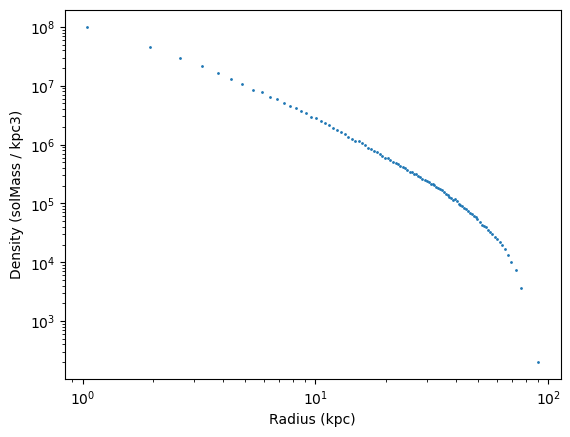

In [8]:
plotdensityfunction(nr_bins = 100, bin_distr = "adaptive", plot_scale = "logarithmic")

Then, several spherically symmetric potentials are computed and later compared. The fits are done in logspace, in order to avoid the imbalanced weighting of the largest densities (several orders of magnitudes larger than most points). Adaptive binning is done, where each point encapsulates the same number of points. This causes the best known regions to be weighted more strongly by providing more points there.

In [9]:
def calcpotentialdensity(bin_radius, potential_name, inputislog, *params):
    r_kpc = bin_radius
    if (inputislog == True):
        r_kpc = 10**bin_radius
    
    r_kpc = r_kpc * units.kpc

    #first 2 parameters are always mass and length scales
    total_mass =  (getdata.masssolar() * len(getdata.coordskpc())) 
    mscale = total_mass
    lscale = params[0] * units.kpc

    #make potential name lowercase, otherwise casesensitive
    potential_name = potential_name.lower()
    
    if (potential_name == "doublepowerlaw"):
        potential = TwoPowerSphericalPotential(amp=mscale, a=lscale, alpha=params[1], beta=params[2])
    elif (potential_name == "hernquist"):
        potential = HernquistPotential(amp=mscale, a=lscale)
    elif (potential_name == "plummer"):
        potential = PlummerPotential(amp=mscale, b=lscale)
    elif (potential_name == "dehnenspherical"):
        potential = DehnenSphericalPotential(amp=mscale, a=lscale, alpha=params[1])
    elif (potential_name == "dehnencorespherical"):
        potential = DehnenCoreSphericalPotential(amp=mscale, a=lscale)
    elif (potential_name == "jaffe"):
        potential = JaffePotential(amp=mscale, a=lscale)
    elif (potential_name == "nfw"):
        potential = NFWPotential(amp=mscale, a=lscale)
    elif (potential_name == "powerspherical"):
        potential = PowerSphericalPotential(amp=mscale, alpha=params[1], normalize=False, r1=lscale)
    elif (potential_name == "powersphericalwcutoff"):
        potential = PowerSphericalPotentialwCutoff(amp=params[1]*(units.Msun / units.kpc**3), alpha=params[2], rc=params[3]*units.kpc, normalize=False, r1=lscale)
    elif (potential_name == "pseudoisothermal"):
        potential = PseudoIsothermalPotential(amp=mscale, a=lscale)
    else:
        raise ValueError(f"Unknown potential: {potential_name}")

    density = potential.dens(r_kpc, z=0*units.kpc, phi=0, t=0, forcepoisson=False).to("solMass/kpc3")
    if (inputislog == True):
        return np.log10(density.value)
    else:
        return density.value

In [10]:
def show_fitparameters_errors(param, bdensity, fitdensity, potentialname):
    bindensity_log = np.log10(bdensity)
    fitdensity_log = np.log10(fitdensity)
    
    residuals = bindensity_log - fitdensity_log         
    rms_error = np.sqrt(np.mean(residuals**2))                          
    
    squaresum_residual = np.sum(residuals**2)
    squaresum_total = np.sum((bindensity_log - np.mean(bindensity_log))**2)
    rsquared_error = 1.0 - (squaresum_residual / squaresum_total)            #relative error

    print("RMSE of " + potentialname + " fit: " + str(rms_error))
    print("RSQUARED of " + potentialname + " fit: " + str(rsquared_error))   #RSQUARED of 1 is best.

In [11]:
def getbestfit(nr_bins=80, bin_distr="adaptive", potential_name="doublepowerlaw"):
    bin_radius, bin_density, bin_poisson_error = getdensityprofile(nr_bins=nr_bins, bin_distr=bin_distr)
    potential_name = potential_name.lower()

    # Log-space setup
    bin_radius_log = np.log10(bin_radius.value)
    bin_density_log = np.log10(bin_density.value)
    inputislog = True

    # Initial parameter guesses
    
    bin_radius_average = sum(bin_radius) / len(bin_radius)
    total_mass =  (getdata.masssolar() * len(getdata.coordskpc())) 
    params = [bin_radius_average.value]

    # Add extra parameters if needed
    if (potential_name == "doublepowerlaw"):
        #alpha, beta
        params += [1.5, 3.5]
    if (potential_name == "dehnenspherical"):
        #alpha
        params += [1.5]
    if (potential_name == "powerspherical"):
        #alpha
        params += [1.5]
    if (potential_name == "powersphericalwcutoff"):
        #density, alpha, rcuttoff
        params += [15.0, 1.5, 10.0]
    
    total_mass =  (getdata.masssolar() * len(getdata.coordskpc())) 
    
    # black magic function to avoid scipy.logfit error (expects r_log as first input)
    def model_for_fit(r_log, *fit_params):
        return calcpotentialdensity(r_log, potential_name, inputislog, *fit_params)
        
    #loglog fit
    popt, pcov = curve_fit(model_for_fit, bin_radius_log, bin_density_log, p0=params)

    params = list(popt)
    print("optimal parameters for " + potential_name + " with mass " + str(total_mass.to("GsolMass")) + ", lengthscale: " + str(params[0]*units.kpc) + ", and other parameters: " + str(params[1:]))
    return params

In [12]:
def plotpotentialdensityfit(nr_bins = 40, bin_distr = "adaptive", potential_name = "doublepowerlaw"):
    bin_radius, bin_density, bin_poisson_error = getdensityprofile(nr_bins=nr_bins, bin_distr=bin_distr)
    fit_parameters = getbestfit(nr_bins=nr_bins, bin_distr=bin_distr, potential_name=potential_name)
    inputislog = False
    
    fit_density = (calcpotentialdensity(bin_radius.value, potential_name, inputislog, *fit_parameters)) * units.Msun / (units.kpc**3)
    show_fitparameters_errors(fit_parameters, bin_density.value, fit_density.value, potential_name)
    
    fig, axs = plt.subplots(2, sharex=False, sharey=False)

    axs[0].scatter(bin_radius, bin_density, s=1, label="data")
    axs[0].plot(bin_radius, fit_density, c="red", label="galpy fit")
    axs[0].set_xscale("log")
    axs[0].set_yscale("log")
        
    axs[1].scatter(bin_radius, bin_density, s=1, label="data")
    axs[1].plot(bin_radius, fit_density, c="red", label="galpy fit")
    axs[1].set_xscale("linear")
    axs[1].set_yscale("linear")
    
    fig.supxlabel("Radius (" + str(bin_radius.unit) + ")") 
    fig.supylabel("Density (" + str(bin_density.unit) + ")") 
        
    plt.suptitle("Best fit of " + potential_name)
    plt.legend()
    plt.tight_layout()
    plt.show()

C:\Users\niels\anaconda3\envs\tana2025\Lib\site-packages\galpy\potential\TwoPowerSphericalPotential.py:170: RuntimeWarning: invalid value encountered in power
  (self.a / r) ** self.alpha

C:\Users\niels\anaconda3\envs\tana2025\Lib\site-packages\galpy\potential\TwoPowerSphericalPotential.py:171: RuntimeWarning: invalid value encountered in power
  / (1.0 + r / self.a) ** (self.beta - self.alpha)

optimal parameters for doublepowerlaw with mass 161.47893455855902 GsolMass, lengthscale: 6.107609034259913 kpc, and other parameters: [np.float64(0.4744828134577401), np.float64(3.2503488870744754)]
RMSE of doublepowerlaw fit: 0.1831986510732197
RSQUARED of doublepowerlaw fit: 0.9619174942309103


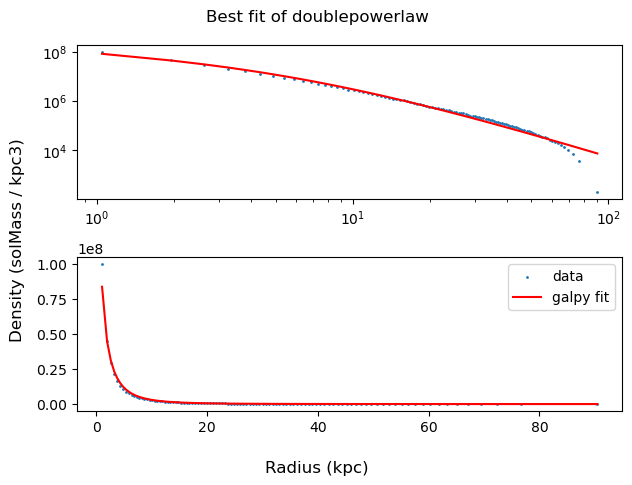

In [13]:
#Fits very well for small lengthscales, but overestimates density at larger scales.
plotpotentialdensityfit(nr_bins = 100, bin_distr = "adaptive", potential_name = "doublepowerlaw")

C:\Users\niels\anaconda3\envs\tana2025\Lib\site-packages\galpy\potential\PowerSphericalPotentialwCutoff.py:62: RuntimeWarning: invalid value encountered in scalar power
  self._amp *= r1**self.alpha

C:\Users\niels\anaconda3\envs\tana2025\Lib\site-packages\galpy\potential\PowerSphericalPotentialwCutoff.py:62: RuntimeWarning: invalid value encountered in scalar power
  self._amp *= r1**self.alpha

C:\Users\niels\anaconda3\envs\tana2025\Lib\site-packages\galpy\potential\PowerSphericalPotentialwCutoff.py:62: RuntimeWarning: invalid value encountered in scalar power
  self._amp *= r1**self.alpha

C:\Users\niels\anaconda3\envs\tana2025\Lib\site-packages\galpy\potential\PowerSphericalPotentialwCutoff.py:62: RuntimeWarning: invalid value encountered in scalar power
  self._amp *= r1**self.alpha

C:\Users\niels\anaconda3\envs\tana2025\Lib\site-packages\galpy\potential\PowerSphericalPotentialwCutoff.py:62: RuntimeWarning: invalid value encountered in scalar power
  self._amp *= r1**self.alpha



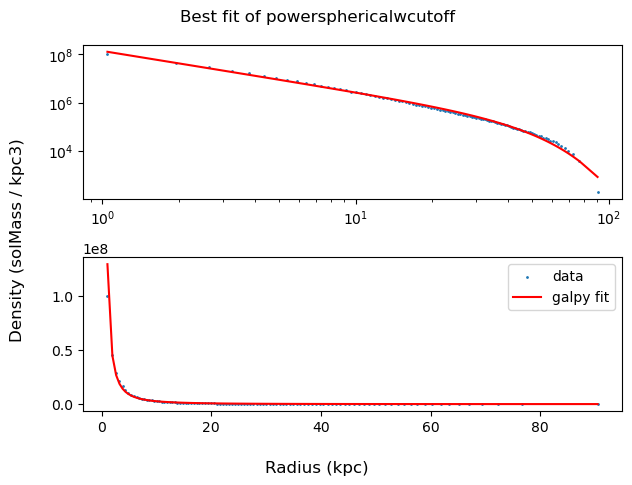

In [14]:
#fundamentally follows the same behaviour as the data This seems to be the best potential for all lengthscales.
plotpotentialdensityfit(nr_bins = 100, bin_distr = "adaptive", potential_name = "powersphericalwcutoff")

C:\Users\niels\AppData\Local\Temp\ipykernel_8748\743650313.py:41: RuntimeWarning: invalid value encountered in log10
  return np.log10(density.value)

optimal parameters for hernquist with mass 161.47893455855902 GsolMass, lengthscale: 12.606868499520235 kpc, and other parameters: []
RMSE of hernquist fit: 0.4713200656883697
RSQUARED of hernquist fit: 0.7479348341311061


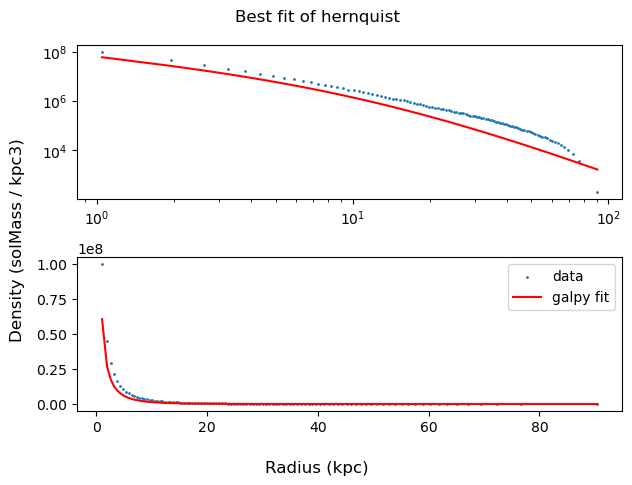

In [15]:
#underperforms if mass-scale is untouched
plotpotentialdensityfit(nr_bins = 100, bin_distr = "adaptive", potential_name = "hernquist")

optimal parameters for plummer with mass 161.47893455855902 GsolMass, lengthscale: 17.576126377912182 kpc, and other parameters: []
RMSE of plummer fit: 0.2586152517097
RSQUARED of plummer fit: 0.9241091808282992


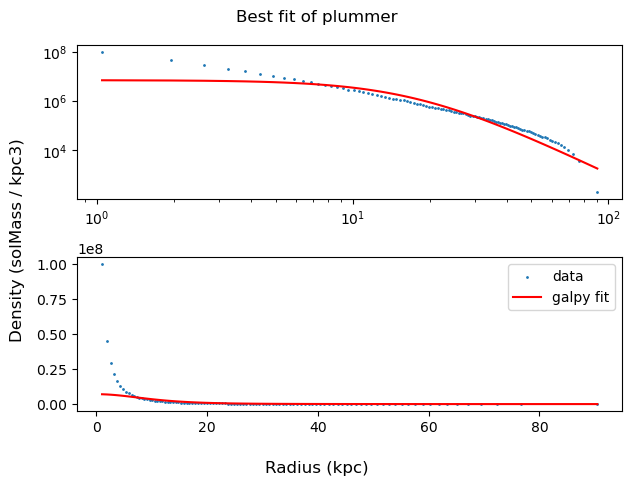

In [16]:
#generally bad
plotpotentialdensityfit(nr_bins = 100, bin_distr = "adaptive", potential_name = "plummer")

C:\Users\niels\anaconda3\envs\tana2025\Lib\site-packages\galpy\potential\TwoPowerSphericalPotential.py:416: RuntimeWarning: invalid value encountered in power
  (self.a / r) ** self.alpha

C:\Users\niels\anaconda3\envs\tana2025\Lib\site-packages\galpy\potential\TwoPowerSphericalPotential.py:417: RuntimeWarning: invalid value encountered in power
  / (1.0 + r / self.a) ** (4.0 - self.alpha)

optimal parameters for dehnenspherical with mass 161.47893455855902 GsolMass, lengthscale: 80.66422914040054 kpc, and other parameters: [np.float64(2.367106576148342)]
RMSE of dehnenspherical fit: 0.24130507742522536
RSQUARED of dehnenspherical fit: 0.9339285414842424


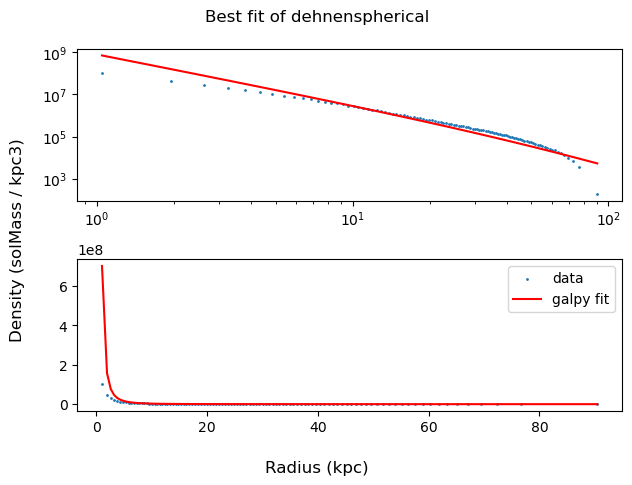

In [17]:
plotpotentialdensityfit(nr_bins = 100, bin_distr = "adaptive", potential_name = "dehnenspherical")

C:\Users\niels\AppData\Local\Temp\ipykernel_8748\743650313.py:41: RuntimeWarning: invalid value encountered in log10
  return np.log10(density.value)

C:\Users\niels\AppData\Local\Temp\ipykernel_8748\743650313.py:41: RuntimeWarning: invalid value encountered in log10
  return np.log10(density.value)

optimal parameters for dehnencorespherical with mass 161.47893455855902 GsolMass, lengthscale: 7.3606408939665 kpc, and other parameters: []
RMSE of dehnencorespherical fit: 0.6264001037661661
RSQUARED of dehnencorespherical fit: 0.5547697994443481


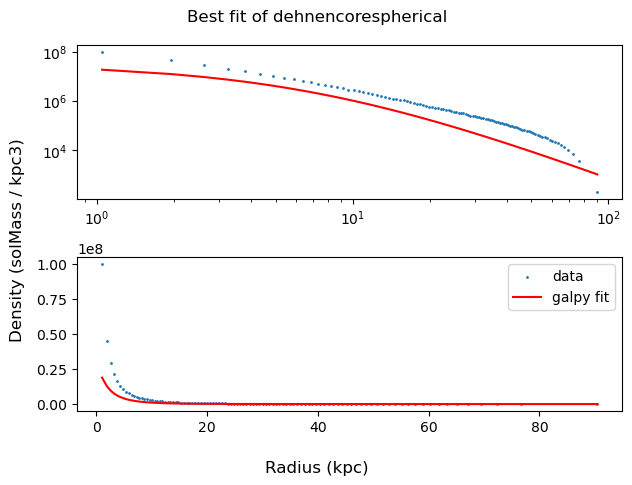

In [18]:
plotpotentialdensityfit(nr_bins = 100, bin_distr = "adaptive", potential_name = "dehnencorespherical")

optimal parameters for jaffe with mass 161.47893455855902 GsolMass, lengthscale: 34.127447207704826 kpc, and other parameters: []
RMSE of jaffe fit: 0.2790045532923677
RSQUARED of jaffe fit: 0.9116709508607052


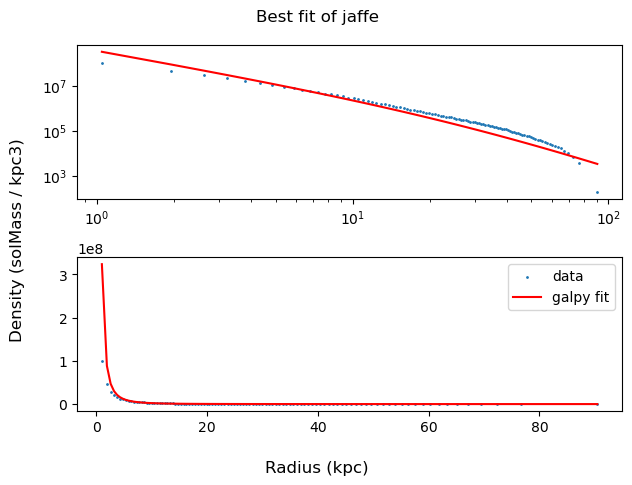

In [20]:
plotpotentialdensityfit(nr_bins = 100, bin_distr = "adaptive", potential_name = "jaffe")

optimal parameters for nfw with mass 161.47893455855902 GsolMass, lengthscale: 12.364699248286717 kpc, and other parameters: []
RMSE of nfw fit: 0.2266946612136353
RSQUARED of nfw fit: 0.9416872452776283


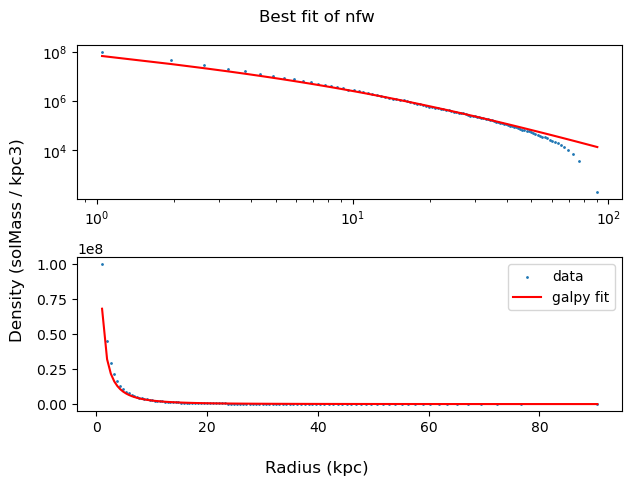

In [21]:
#only performs well in well-probed lengthscale, as seen in lectures
plotpotentialdensityfit(nr_bins = 100, bin_distr = "adaptive", potential_name = "nfw")

optimal parameters for powerspherical with mass 161.47893455855902 GsolMass, lengthscale: 9434.360485771194 kpc, and other parameters: [np.float64(2.3865332315840457)]
RMSE of powerspherical fit: 0.24528112610566963
RSQUARED of powerspherical fit: 0.9317332486620591


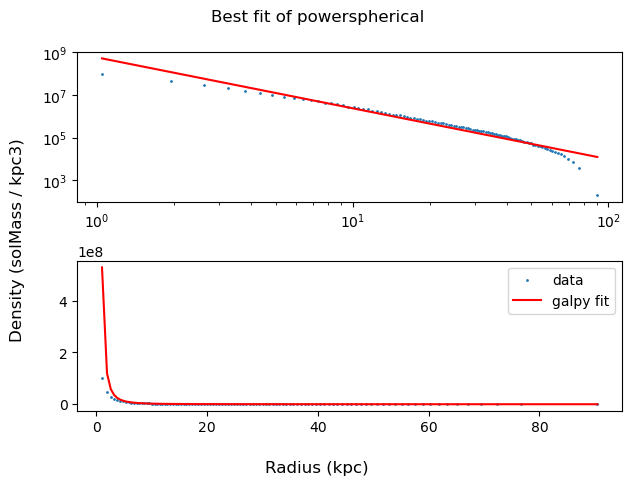

In [22]:
plotpotentialdensityfit(nr_bins = 100, bin_distr = "adaptive", potential_name = "powerspherical")